# EDA notebook

Import

In [19]:
pip install statsmodels


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 9.1/9.1 MB 9.0 MB/s eta 0:00:00
     -------------------------------------- 233.8/233.8 kB 4.8 MB/s eta 0:00:00


In [1]:
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import glob


Metadata are given in the "train.csv" file, that is where the we have can find wether the patient has cancer or not along with other pieces of information.  
Information about the view and laterality is given and could be useful when training our model.



- `site_id` - ID code for the source hospital.
- `patient_id` - ID code for the patient.
- `image_id` - ID code for the image.
- `laterality` - Whether the image is of the left or right breast.
- `view` - The orientation of the image. The default for a screening exam is to capture two views per breast.
- `age` - The patient's age in years.
- `implant` - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- `density` - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make  diagnosis more difficult. Only provided for train.
- `machine_id` - An ID code for the imaging device.
- `cancer` - Whether or not the breast was positive for cancer. The target value. Only provided for train.
- `biopsy` - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- `invasive` - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- `BIRADS` - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- `prediction_id` - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
- `difficult_negative_case` - True if the case was unusually difficult. Only provided for train.


In [2]:
train_csv = pd.read_csv("data/train.csv")
train_csv[:5]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
print("The number of images is ",len(train_csv))
print("The number of patient is ",train_csv.patient_id.nunique())

The number of images is  54706
The number of patient is  11913


In [4]:
test_csv = pd.read_csv("data/test.csv")
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


We can see that we do not have access to all the information in the test sample  

Here is an example of a patient having a cancer

In [5]:
train_csv[train_csv.patient_id==106]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
582,2,106,76321767,L,CC,65.0,1,1,1,NaN,0,NaN,21,False
583,2,106,2018825992,L,MLO,65.0,1,1,1,NaN,0,NaN,21,False
584,2,106,1160585918,R,CC,65.0,0,0,0,NaN,0,NaN,21,False
585,2,106,1495797827,R,MLO,65.0,0,0,0,NaN,0,NaN,21,False


### Data explore

Let's take a look at different features distribution, starting from the cancer rate

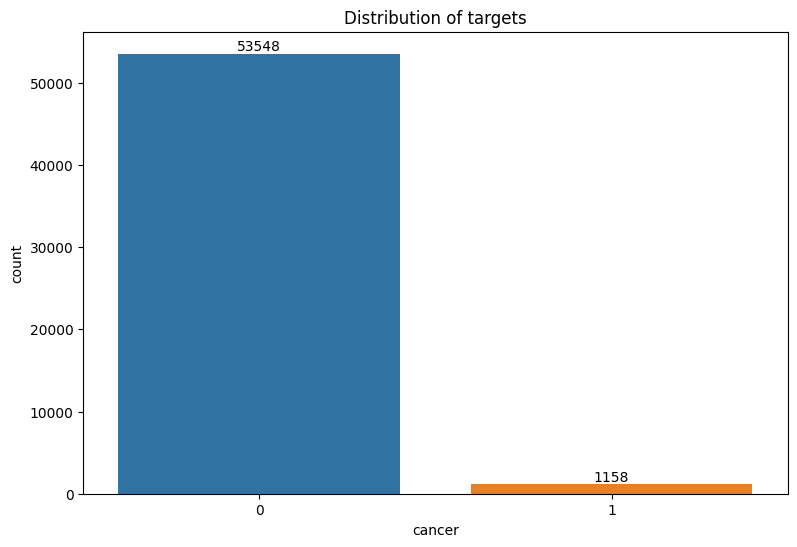

In [6]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_csv, x='cancer')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Distribution of targets');

But what does it mean when looking at the number of patient having a cancer ?

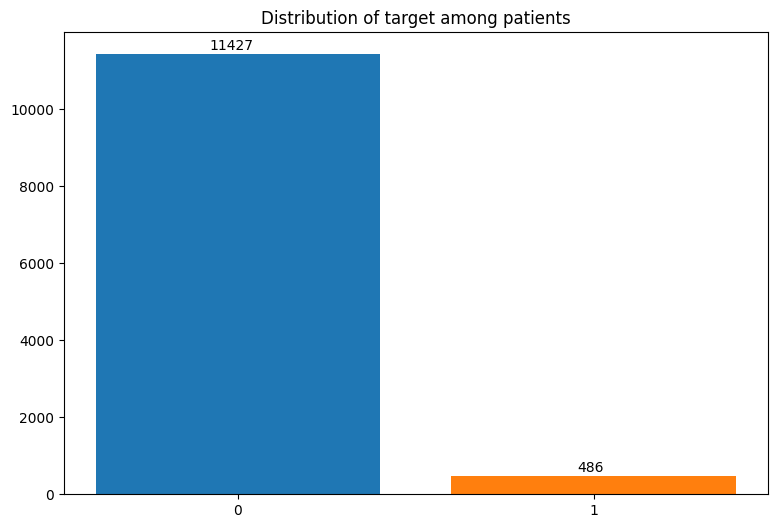

In [7]:
patient_cancer = train_csv.groupby('patient_id')['cancer'].max()
type(patient_cancer)
np_cancer = patient_cancer.values.sum()
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
heights = [train_csv.patient_id.nunique() - np_cancer, np_cancer]
ax1 = plt.bar([0,1],heights,color = ["tab:blue","tab:orange"],label = ["0","1"])
plt.title("Distribution of target among patients")
plt.xticks([0,1], [0,1])
plt.text(x = -0.08 , y = heights[0]+100, s = str(heights[0]), size = 10)
plt.text(x = 0.955 , y = heights[1]+100, s = str(heights[1]), size = 10)
plt.show()

We will now try to see the correlation between the metadata and the probability of having cancer.  

**Remark** The cancer indicator is not 1 for all the images of one patient (can have something on the left breast and not on the right, or can be visible from only one angle)

C:\Users\rnamyst\AppData\Local\Temp\ipykernel_18392\1302511687.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ages = train_csv.groupby('patient_id')['cancer','age'].apply(lambda l:np.max(l))
c:\Users\rnamyst\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


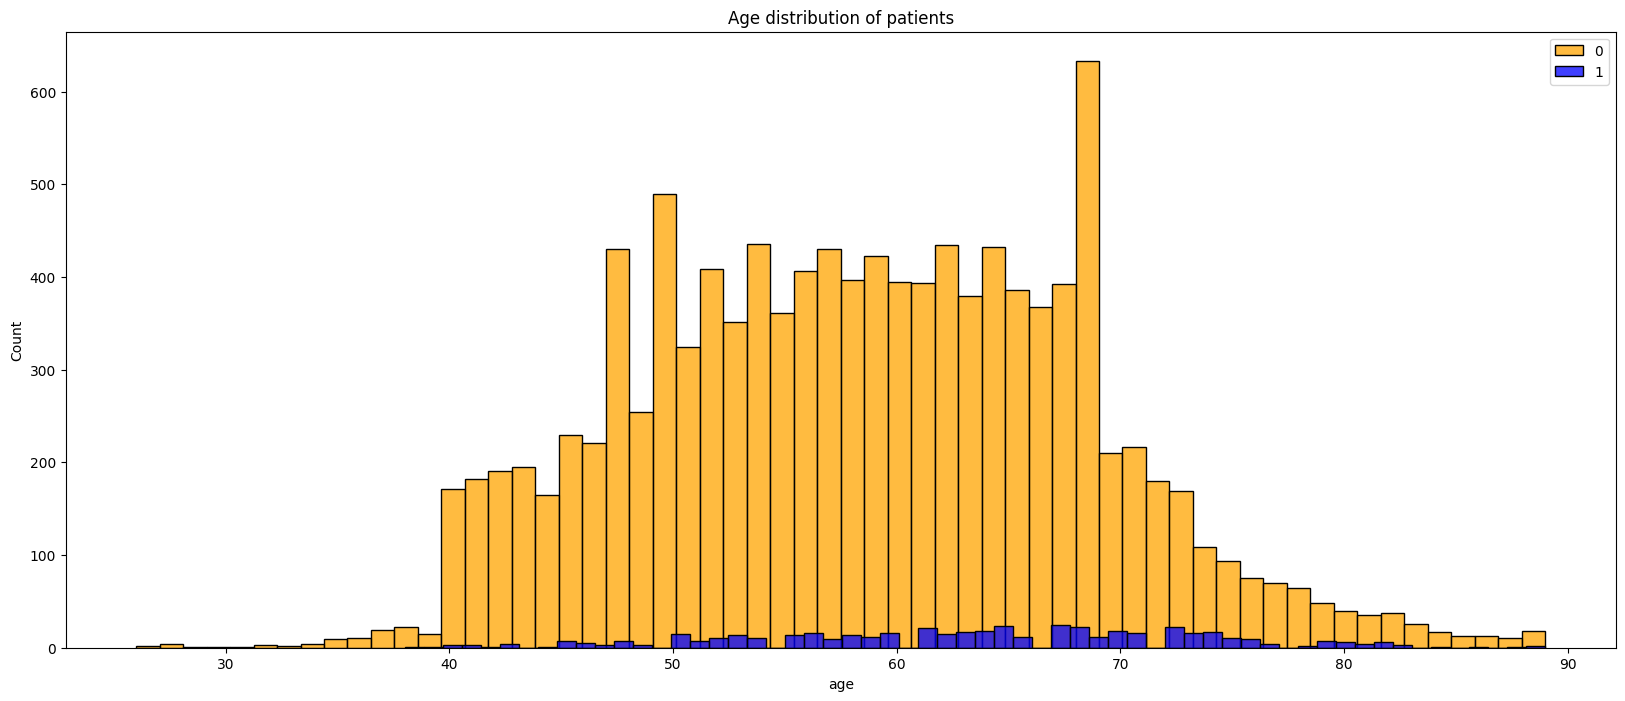

In [8]:
ages = train_csv.groupby('patient_id')['cancer','age'].apply(lambda l:np.max(l))

ages_cancer = ages[ages.cancer==1].age
ages_healthy = ages[ages.cancer==0].age
plt.figure(figsize=(20,8))

sns.histplot(ages_healthy, color='orange', bins=60,label='0')
sns.histplot(ages_cancer,color='blue',bins=60,label='1')
plt.legend()
plt.title('Age distribution of patients');

In [14]:
print("The average age for healthy patient is ", ages_healthy.mean(), "with a standard deviation of ",ages_healthy.std())
print("The average age for patient with cancer is ", ages_cancer.mean(),"with a standard deviation of ",ages_cancer.std())


The average age for healthy patient is  58.43156143269989 with a standard deviation of  9.832888435148368
The average age for patient with cancer is  63.49382716049383 with a standard deviation of  9.875459689833624


In [16]:
features = ["age"]
train_csv[features].describe().T.style.bar(subset=['mean'])\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')


,count,mean,std,min,25%,50%,75%,max
age,54669.000000,58.543928,10.050884,26.000000,51.000000,59.000000,66.000000,89.000000


The majority of the patient are between 50 and 70. There is a slight shift in the distribution of the patient having cancer

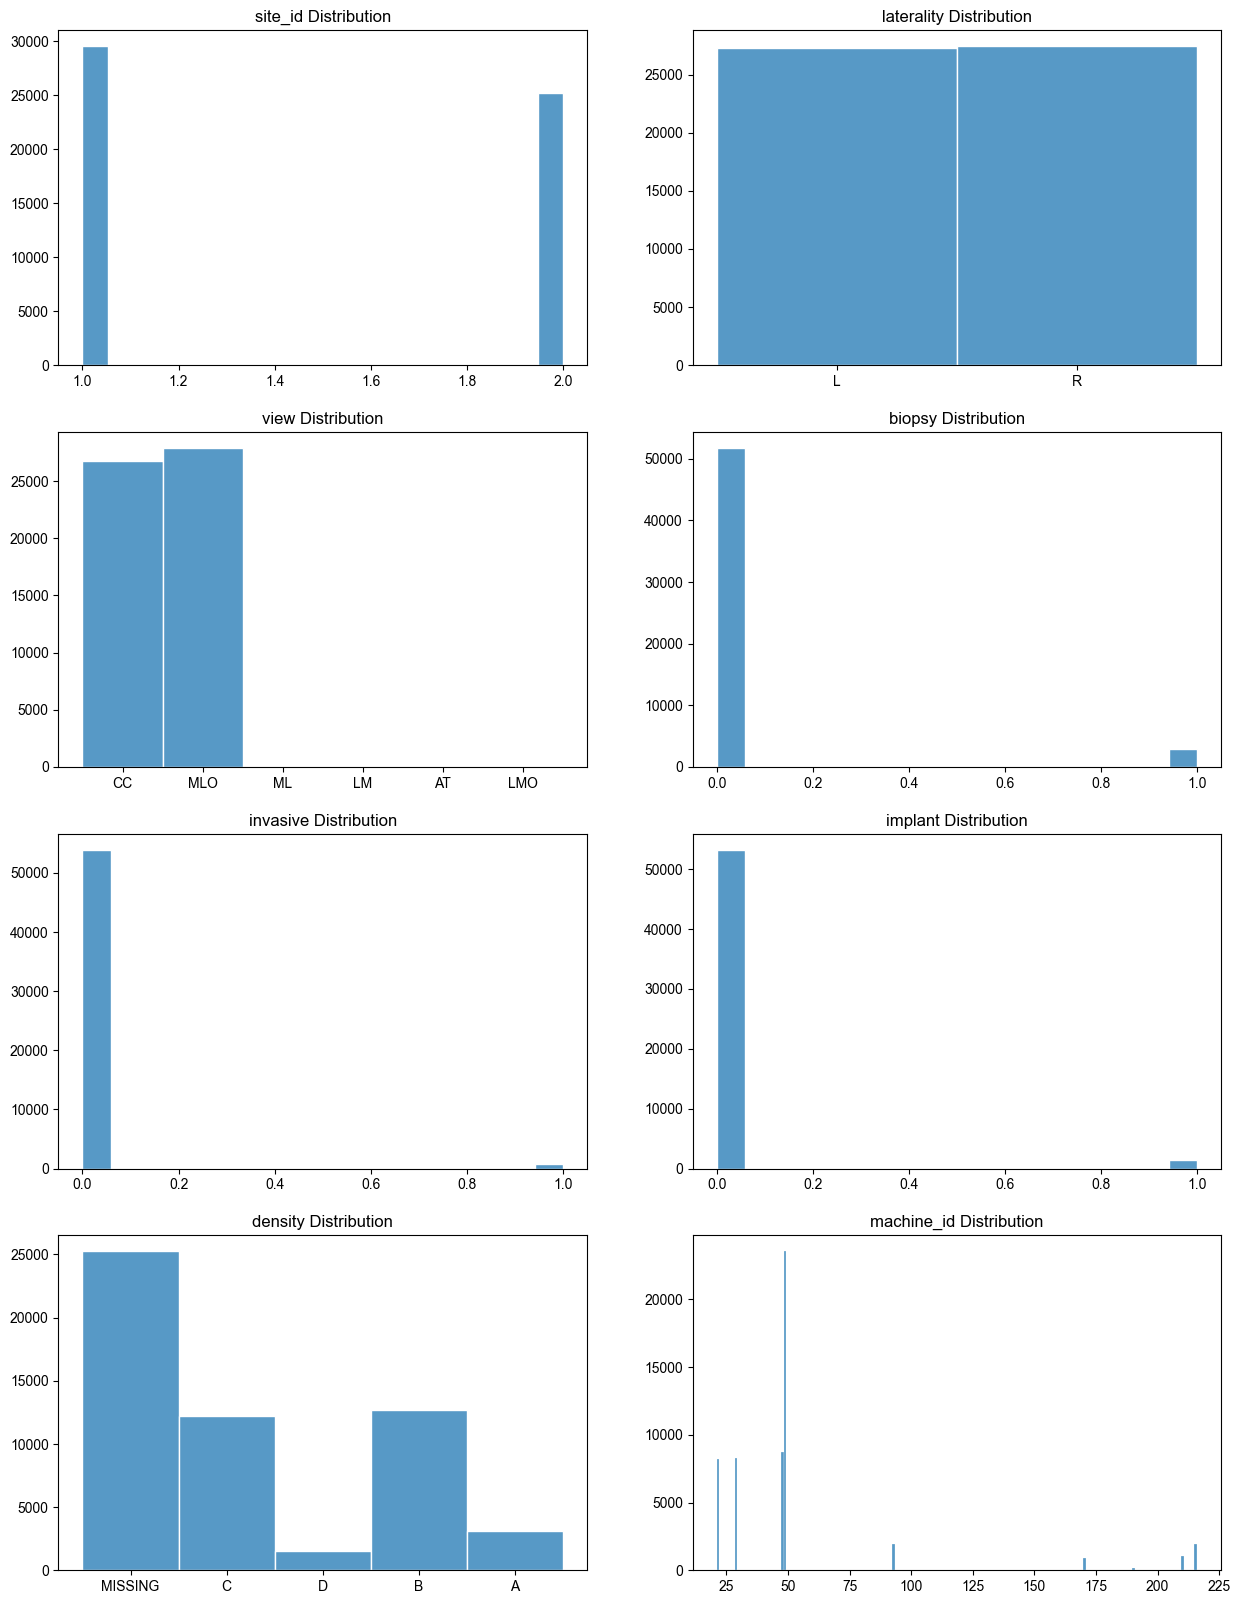

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

train_subset = train_csv.copy()
train_subset["density"] = train_subset["density"].fillna("MISSING")
features = ["site_id", "laterality", "view", "biopsy", "invasive", "implant", "density", "machine_id"]
axs = axs.flatten()

for i, feature in enumerate(features):
    _ = sns.histplot(train_subset, x="{}".format(feature), ax=axs[i])
    _ = axs[i].set_title("{} Distribution".format(feature))
    _ = axs[i].set_ylabel("")
    _ = axs[i].set_xlabel("")

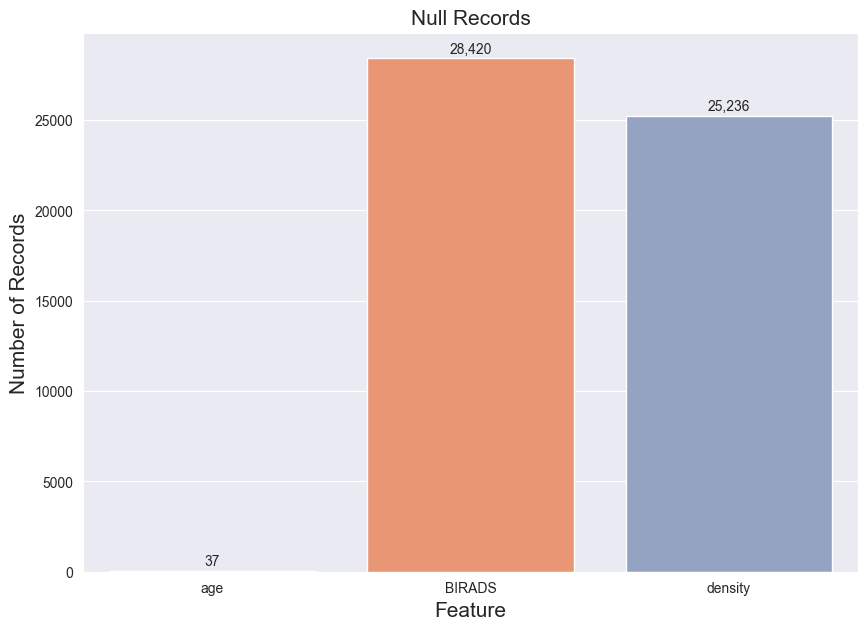

In [10]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

null_values = train_csv.isna().sum().loc[lambda x: x > 0]
_ = sns.barplot(x=null_values.index, y=null_values.values, ax=axs)
for p in axs.patches:
    axs.text(x=p.get_x()+(p.get_width()/2), y=p.get_height()+300, s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs.set_title("Null Records", fontsize=15)
_ = axs.set_ylabel("Number of Records", fontsize=15)
_ = axs.set_xlabel("Feature", fontsize=15)

We see that only a few patient are missing information about their age, replacing the Null values with the mean age is a solution.  
For the `BIRADS` and `density` features, there too many Null values, we can't just replace it, meaning that we will need to understand these features or to ignore them as they do not appear in the test sample.

### P-value testing

While looking at features visually will tell us some interesting information, we can also use p-value testing to see if a feature has a net impact on a simple regression model. This method is controversial in that it likely doesn't provide a correct look at what features are informative. Our null hypothesis is that the feature impacts the target variable of cancer. In this case, anything with a p-value greater than 0.05 means we reject that hypothesis, and can potentially flag it for removal. Before we begin our analysis, we will also have to deal with missing values. For the age feature, we will use the mean age of the training set. For BIRADS we set it to a value of 10 to indicate an impossible score.

In [20]:
features = [
    "site_id", "age", "biopsy", "invasive", 
    "BIRADS", "implant", "machine_id"
]

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_subset = train_csv.copy()
train_subset["age"] = train_subset["age"].fillna(51)
train_subset["density"] = train_subset["density"].fillna("MISSING")
train_subset["BIRADS"] = train_subset["BIRADS"].fillna(10)
x = add_constant(train_subset[features])
model = OLS(train_subset["cancer"], x).fit()

pvalues = pd.DataFrame(model.pvalues)
pvalues.reset_index(inplace=True)
pvalues.rename(columns={0: "pvalue", "index": "feature"}, inplace=True)
pvalues.style.background_gradient(cmap='YlOrRd')

,feature,pvalue
0,const,0.000000
1,site_id,0.000311
2,age,0.000000
3,biopsy,0.000000
4,invasive,0.000000
5,BIRADS,0.000000
6,implant,0.197777
7,machine_id,0.087494


The `implant` field has a p-value of 0.198.  
The `machine_id` field has a p_value of 0.087.  
This suggests that it has little impact on our classifier and may be a candidate for removal.

### Spearman correlation

We should also check to see what variables are correlated to one another. Spearman correlation does not make assumptions about distribution types or linearity. With Spearman correlation, we have values that range from -1 to +1. Values around either extreme end mean a neagative or positive correlation respectively, while those around 0 mean no correlation exists.

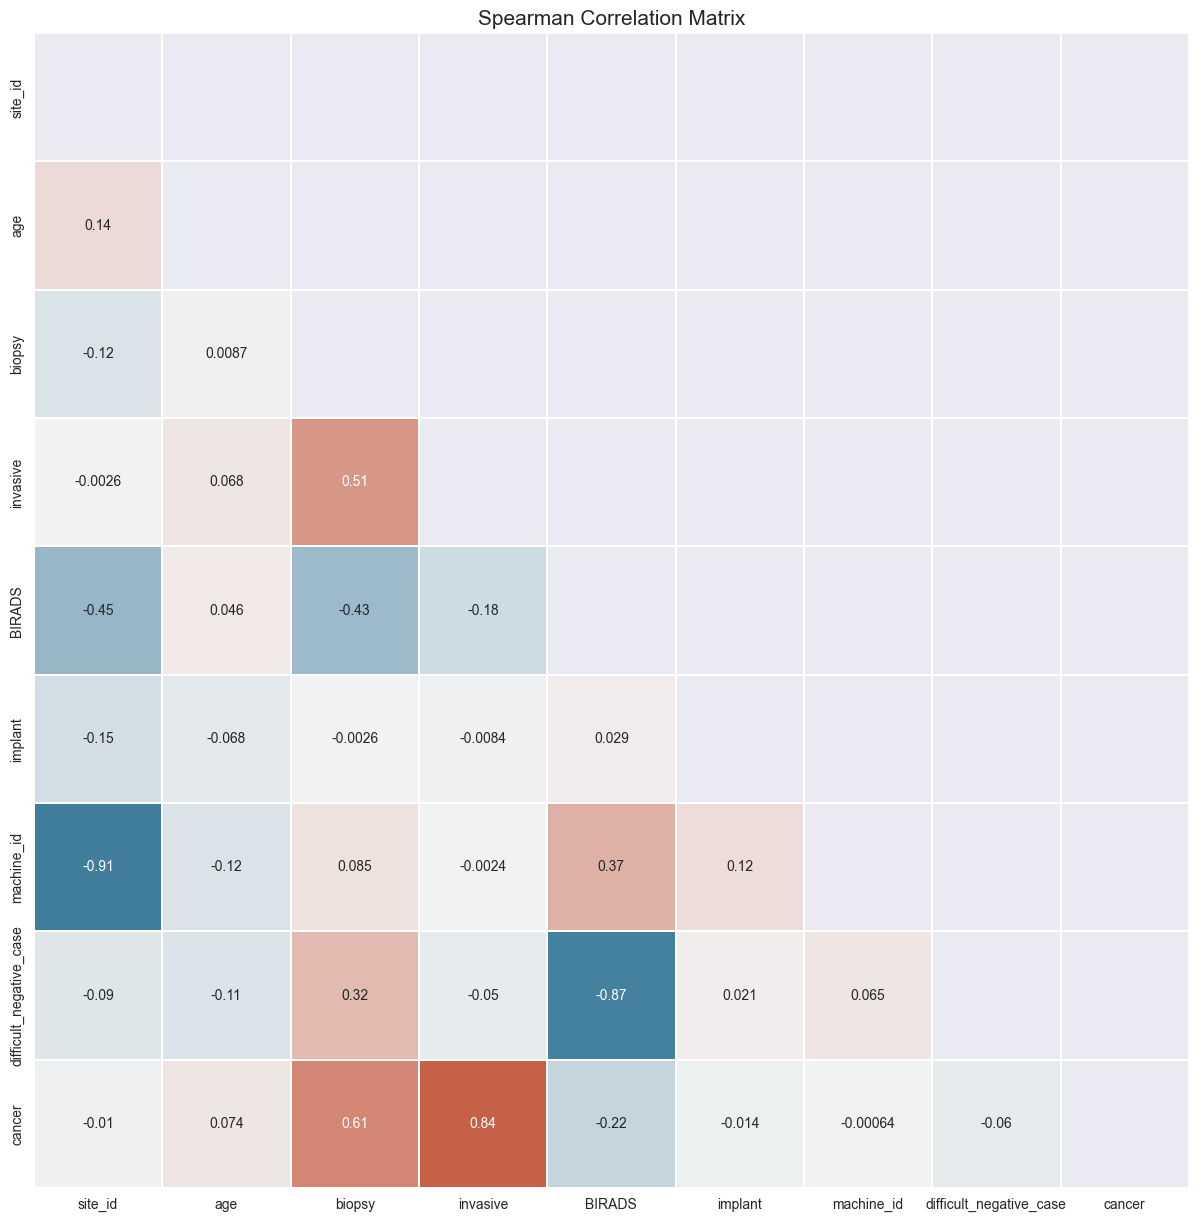

In [21]:
features = [
    "site_id", "age", "biopsy", "invasive", 
    "BIRADS", "implant", "machine_id", "density",
    "difficult_negative_case", "cancer"
]
correlation_matrix = train_csv[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)

### DICOM image format overview

**DICOM** (Digital Imaging and Communications in Medicine), developed by National Electrical Manufacturers Association, allows you to create, store, send and print single image, a series of images, patient information, research, equipment, facilities, medical personnel providing inspection, etc.

DICOM Standard defines two informational levels:

- File Level - DICOM File object is a file with tags that contain information about the organization for the representation of the image frame (or series of frames) and accompanying / control information (in the form of DICOM tags);
- Network (Communication) Level — DICOM Network Protocols — to transfer DICOM files, DICOM and control commands across networks with TCP / IP support.

The file layer of the 2008 DICOM 3.0 standard describes:

- patient attributes and demographics;
- model and company of the manufacturer of the device on which the survey was carried out;
- attributes of the medical institution where the survey was carried out;
- attributes of the personnel who examined the patient;
- type of examination and time of its conduct;
- conditions and parameters of the patient's examination;
- parameters of an image or a series of images recorded in a DICOM file;
- unique identification keys Unique Identifier (UID) of data groups described in the DICOM file.
- image, series or set of series obtained during the examination of the patient.
- presentation, first of all, of PDF documents in a DICOM file.
- representation of DICOM-recording on optical media, including DVD-format.
- DICOM protocol for transmission and reception over TCP / IP.

DICOM files contain metadata in addition to the image. For example: age, gender, study modality, name, body part and body position.

**For example: BitsAllocated and PhotometricInterpretation.**

The Photometric Interpretation value determines the intended interpretation of the pixel data.

Here we are interested in the main two values for the X-ray:

- MONOCHROME1 - Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as white after any VOI gray scale transformations have been performed.
- MONOCHROME2 - Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as black after any VOI gray scale transformations have been performed.

Bits Allocated - Number of bits allocated for each pixel sample. Each sample shall have the same number of bits allocated. Bits Allocated shall be either 1, or a multiple of 8.

In [ ]:
pydicom.dcmread("data/train_images/10006/1459541791.dcm")

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

In [ ]:
# source: https://www.kaggle.com/code/allunia/rsna-csf-cervical-spine-fracture-eda/notebook
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    data = dcm_ds.pixel_array
    if dcm_ds.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    return data * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

In [ ]:
def show_images_for_patient(patient_id):
    patient_dir = os.path.join('data/train_images', str(patient_id))
    num_images = len(glob.glob(f"{patient_dir}/*"))
    print(f"Number of images for patient: {num_images}")
    fig, axs = plt.subplots(2, 2, figsize=(24,15))
    axs = axs.flatten()
    for i, img_path in enumerate(list(Path(patient_dir).iterdir())):
        ds = pydicom.dcmread(img_path)
        axs[i].imshow(rescale_img_to_hu(ds), cmap="bone")

Number of images for patient: 4


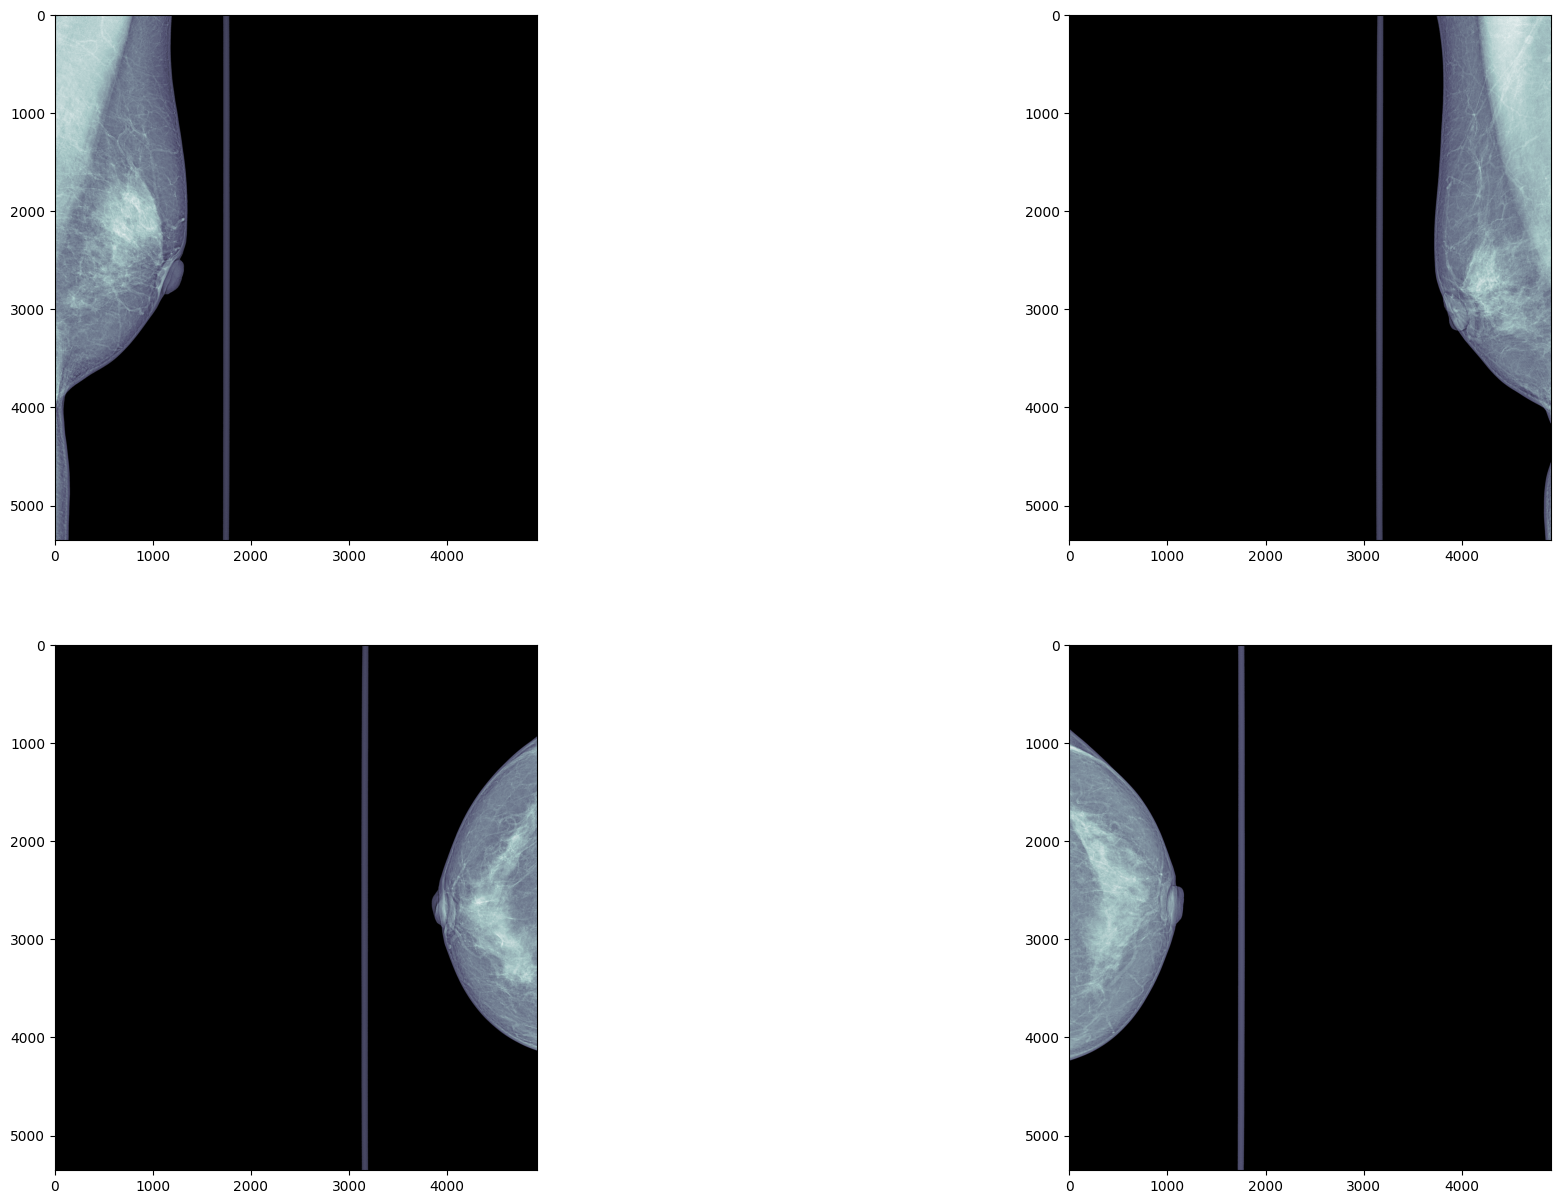

In [ ]:
show_images_for_patient(10006)

We can see that most of the image is black and thus not important.  
The size of the image is huge too.  
As we do not have access to unlimited computation power, we'll need to resize in a smart way the data we have. 